# Accuracy of BlueSTARR-predicted effects of mutation: AUC

The idea here is to assess the accuracy of BlueSTARR model predictions by comparing its predicted effects of mutations to some sort of ground-truth data. Here we will be using variant effect calls using **B**ayesian **I**nference of **R**egulatory **D**ifferences ([BIRD](http://www.geneprediction.org/bird/)) to determine variants with a high probability of having a transcriptional effect (positive or negative).

## Setup

### Imports

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path

### Paths to data and databases

In [3]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MUT_PRED_DB = DB_ROOT / 'cCRE-preds-K562'
BIRD_DIR = DATA_ROOT / "kd259"
BIRD_FILE = BIRD_DIR / "out.all.txt"
BIRD_COUNTS = BIRD_DIR / "BIRD_files" / "BIRD_input.K562.2024_07_18.txt"

## Load BIRD calls and BIRD input read counts

### BIRD calls

The columns in the file with BIRD calls are:
1. Variant ID = identifier of the variant tested, formatted as chrom:pos:ref:alt. Note that the variant position is a 1-based coordinate.
2. Effect size (theta) = posterior median of effect size under the model.  This effect size can be interpreted as the transcriptional rate of the alternate allele divided by the transcriptional rate of the reference allele.  An effect of 0.5 means that the alternate allele halves the transcriptional rate.  Effect sizes tend to be between 0.5 and 2 for real regulatory variants.  An effect size close to 1 means no effect.
3. Lower CI = lower bound of 95% credible interval.
4. Upper CI = upper bound of 95% credible interval.
5. $P_{reg}$ = posterior probability that the variant has a regulatory effect.  This probability reflects the lambda value specified in the BIRD command.  If you specified 1.25 (as recommended), $P_{reg}$ will be the posterior probability that the effect size is greater than 1.25 or less than 1/1.25.


In [4]:
pred_table = pl.scan_csv(BIRD_FILE, separator="\t", has_header=False,
                         new_columns=["variantID", "theta", "lowerCI", "upperCI", "P_reg"])


In [5]:
bird_calls = pred_table.with_columns(
    pl.col('variantID').str.split(':')
    .list.to_struct(fields=['chrom', 'allele_pos','ref_allele','alt_allele'])
).unnest('variantID').filter(
    pl.col('ref_allele').str.len_bytes() == 1,
    pl.col('alt_allele').str.len_bytes() == 1
).with_columns(
    pl.col('allele_pos').cast(pl.UInt32).add(-1),
)

### BIRD input read counts

BIRD calls are computed from input read counts for DNA (_input_) and RNA (_output_) replicates. It is possible to obtain a $P_{reg}\leq t$ for a "true negative" threshold _t_ _"simply because of the shrinkage prior overwhelming the data when read counts are low."_

We therefore include the read counts that served as input to BIRD, so we can threshold on those values, too. Specifically, we compute the average input read counts for both the reference and the alternate allele.

#### Determine column names

The columns of the read counts file are variable and are determined by the number of DNA ("input") and RNA ("output") replicates. Specifically, the are in the following order (example for 3 replicates for both DNA and RNA):
- Variant ID (chrom:pos:ref:alt with 1-based pos)
- Input replicate count
- Input 1 reference count
- Input 1 alternate count
- Input 2 reference count
- Input 2 alternate count
- Input 3 reference count
- Input 3 alternate count
- Output replicate count
- Output 1 reference count
- Output 1 alternate count
- Output 2 reference count
- Output 2 alternate count
- Output 3 reference count
- Output 3 alternate count

To determine the names for columns after the input replicate count, we take a peek at the file, and then compute names from the number of replicates.

In [6]:
peek = pd.read_csv(BIRD_COUNTS, sep='\t', header=None, nrows=50, na_values='NA')
inputs_count = peek[1].unique()
if len(inputs_count) > 1:
    raise ValueError(f"Expected a single unique input count, got {inputs_count}")
outputs_count = peek[2 + 2*inputs_count[0]].unique()
if len(outputs_count) > 1:
    raise ValueError(f"Expected a single unique output count, got {outputs_count}")
colnames = (
    ['variantID', 'n_inputs'] + 
    [f"input{i}_{suffix}" for i in range(1, inputs_count[0] + 1) for suffix in ("ref", "alt")] + 
    ['n_outputs'] +
    [f"output{i}_{suffix}" for i in range(1, outputs_count[0] + 1) for suffix in ("ref", "alt")]
)

#### Parse and process counts file

In [7]:
bird_counts = pl.scan_csv(BIRD_COUNTS, separator='\t', has_header=False,
                          new_columns=colnames, null_values=['NA'])
bird_counts = bird_counts.with_columns(
    pl.col('variantID').str.split(':')
    .list.to_struct(fields=['chrom', 'allele_pos','ref_allele','alt_allele'])
).unnest('variantID').filter(
    pl.col('ref_allele').str.len_bytes() == 1,
    pl.col('alt_allele').str.len_bytes() == 1
).with_columns(
    pl.col('allele_pos').cast(pl.UInt32).add(-1),
).drop_nans().with_columns(
    avg_input_ref=pl.mean_horizontal(pl.col("^input[0-9]+_ref$")),
    avg_input_alt=pl.mean_horizontal(pl.col("^input[0-9]+_alt$")),    
)

## Merge with BlueSTARR mutation predictions

### Database with BlueSTARR predictions from saturated mutagenesis of cCREs

In [8]:
mutpreds = duckdb.read_parquet(str(DB_ROOT / f'{MUT_PRED_DB}/**/*.parquet'), hive_partitioning=True)


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from te join conditions, we can check that indeed the reference alleles are the same from both tables.

In [9]:
blue_birds = duckdb.sql(
    "select b.chrom, m.allele_pos, b.ref_allele, b.alt_allele, b.theta, b.lowerCI, b.upperCI, b.p_reg, "
    "m.ref_allele as blue_ref_allele, m.log2FC, c.avg_input_ref, c.avg_input_alt "
    "from bird_calls b, mutpreds m, bird_counts c "
    "where b.chrom = m.chrom and b.chrom = c.chrom "
    "and b.allele_pos = m.allele_pos and b.allele_pos = c.allele_pos "
    "and b.alt_allele = m.allele and b.alt_allele = c.alt_allele")

It's not necessary for the ROC curve analysis, but to make sanity inspection easier we order by chromosomal position and alt allele. 

In [10]:
bb_df = blue_birds.df().sort_values(['chrom', 'allele_pos', 'alt_allele'])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
bb_df

,chrom,allele_pos,ref_allele,alt_allele,theta,lowerCI,upperCI,P_reg,blue_ref_allele,log2FC,avg_input_ref,avg_input_alt
0,chr1,139057,C,G,0.988454,0.758482,1.240670,0.054,C,0.008718,98.333333,21.333333
1,chr1,181392,G,C,1.030300,0.798790,1.495150,0.132,G,-0.032558,40.000000,11.000000
2,chr1,181468,G,A,0.487996,0.261877,0.901602,0.927,G,-0.002900,55.000000,11.000000
4,chr1,181507,G,C,0.928912,0.582267,1.181070,0.206,G,-0.004882,63.000000,14.000000
3,chr1,181569,G,A,0.937604,0.314720,1.467280,0.290,G,-0.004441,79.666667,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
390051,chr9,138050483,G,C,0.898340,0.490950,1.162150,0.315,G,-0.008928,33.000000,11.333333
390052,chr9,138071420,C,T,1.011670,0.783840,1.504290,0.092,C,-0.004002,18.666667,37.666667
390053,chr9,138098192,T,A,0.434455,0.114793,1.063190,0.790,T,0.041753,42.000000,4.000000
390054,chr9,138098495,G,A,0.945288,0.471378,1.505700,0.225,G,-0.016944,3.666667,33.666667


Sanity check: for every position, the reference alleles between BIRD and BlueSTARR should be the same.

In [12]:
bb_df.loc[bb_df['ref_allele'] != bb_df['blue_ref_allele']]

,chrom,allele_pos,ref_allele,alt_allele,theta,lowerCI,upperCI,P_reg,blue_ref_allele,log2FC,avg_input_ref,avg_input_alt


### Write matched table to file

In [13]:
bb_df.to_csv(DB_ROOT / 'blue_bird.csv.gz', index=False)

## ROC display and AUC

### Define positive and negative classes

We define the positive class as variants with $P_{reg}$ greater than some threshold, and the negative class as variants with $P_{reg}$ less than some threshold.

In [14]:
Preg_pos = 0.9
Preg_neg = 0.3

In [15]:
pos_label = f"BIRD P_reg ≥ {Preg_pos}"
neg_label = f"BIRD P_reg ≤ {Preg_neg}"
bb_df['label'] = None
bb_df.loc[bb_df['P_reg'] >= Preg_pos, 'label'] = pos_label
bb_df.loc[bb_df['P_reg'] <= Preg_neg, 'label'] = neg_label

### Subset predictions into those with positive and negative effects

In [16]:
bb_df_pos = bb_df.loc[bb_df['label'].notna() & (bb_df['theta'] > 1)]
bb_df_neg = bb_df.loc[bb_df['label'].notna() & (bb_df['theta'] < 1)]

How many positives and negatives?

In [17]:
bb_df_pos.value_counts('label')

label
BIRD P_reg ≤ 0.3    109345
BIRD P_reg ≥ 0.9      4235
Name: count, dtype: int64

In [18]:
bb_df_neg.value_counts('label')

label
BIRD P_reg ≤ 0.3    108087
BIRD P_reg ≥ 0.9      8047
Name: count, dtype: int64

### ROC curve display and AUC calculation

In [19]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt

Allow subsetting all classes or only the TN class by minimum average input count:

In [20]:
def subset_by_avg_input(df, min_avg_input, pos_label=None, neg_label=None):
    if pos_label is None:
        return df.loc[df['avg_input_ref'] >= min_avg_input]
    else:
        return df.loc[((df['avg_input_ref'] >= min_avg_input) & (df['label'] == neg_label)) |
                      (df['label'] == pos_label)]

In [21]:
bb_df_pos_gt10 = subset_by_avg_input(bb_df_pos, 10, pos_label=pos_label, neg_label=neg_label)
bb_df_neg_gt10 = subset_by_avg_input(bb_df_neg, 10, pos_label=pos_label, neg_label=neg_label)
bb_df_pos_gt30 = subset_by_avg_input(bb_df_pos, 30, pos_label=pos_label, neg_label=neg_label)
bb_df_neg_gt30 = subset_by_avg_input(bb_df_neg, 30, pos_label=pos_label, neg_label=neg_label)

Text(0.5, 1.0, 'BlueSTARR effect prediction accuracy')

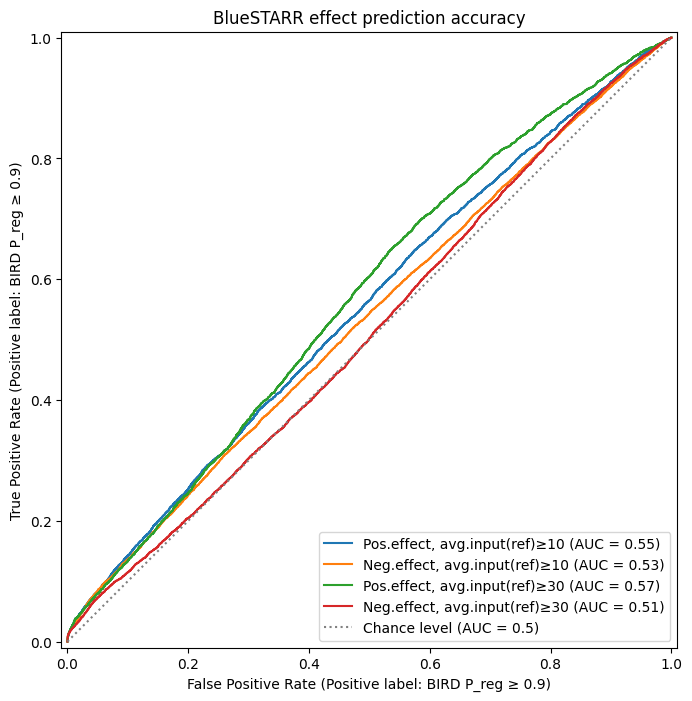

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_gt10['label'],
    bb_df_pos_gt10['log2FC'], pos_label=pos_label,
    name='Pos.effect, avg.input(ref)≥10', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg_gt10['label'],
    -bb_df_neg_gt10['log2FC'], pos_label=pos_label,
    name='Neg.effect, avg.input(ref)≥10', ax=ax)
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_gt30['label'],
    bb_df_pos_gt30['log2FC'], pos_label=pos_label,
    name='Pos.effect, avg.input(ref)≥30', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg.loc[bb_df_neg['avg_input_ref'] >= 50, 'label'],
    -bb_df_neg.loc[bb_df_neg['avg_input_ref'] >= 50, 'log2FC'], pos_label=pos_label,
    name='Neg.effect, avg.input(ref)≥50', ax=ax,
    plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
ax.set_title('BlueSTARR effect prediction accuracy')


### Plot BlueSTARR predictions vs BIRD predictions

We'll want both predictions at $\log_2$, and so that we can refer to the BIRD predictions by column name, add those values to the dataframes.

In [18]:
bb_df_pos = bb_df_pos.assign(log2theta=np.log2(bb_df_pos['theta']))
bb_df_neg = bb_df_neg.assign(log2theta=np.log2(bb_df_neg['theta']))

Then combine the two so we can have a faceted plot, with the facet being the direction (or "type" for short) of the predicted change.

In [21]:
bb_df_combined = pd.concat([bb_df_pos, bb_df_neg], keys=['Positive', 'Negative'], names=['Effect_Type'])

Then plot:

In [22]:
import seaborn as sns

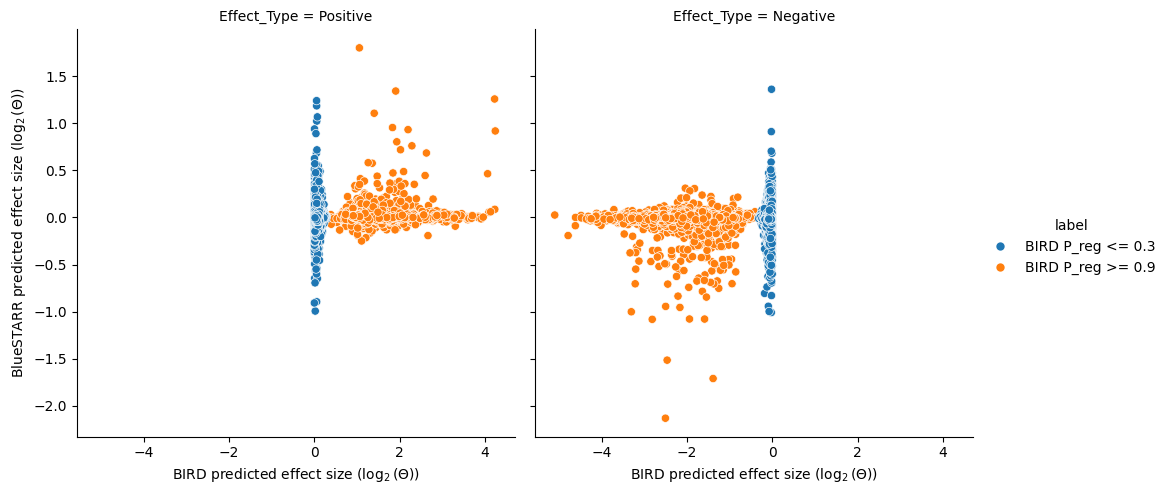

In [29]:
g = sns.relplot(data=bb_df_combined,
                x='log2theta', y='log2FC', hue='label', col='Effect_Type', kind='scatter')
g.set_xlabels('BIRD predicted effect size ($\log_2(\Theta)$)')
g.set_ylabels('BlueSTARR predicted effect size ($\log_2(\Theta)$)')